In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

from ALT_F_BIND_chromo_vertex_nuclear_competitive_2_density import *

In [2]:
# chrmosome 16, Gm12878
# 1) process chr 16 Gm12878 chipseq data according to quinn Bottom up modeling paper 
#     bigwig file from quinn bottom up paper citation, then converted to bedGraph using bigWigToBedGraph from UCSC command line tool on WSL

# 2) Generate HP1 binding profile 

# 3) find chr 16 intrachromosome Hi-C data 
#     from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525, chr 16, MAPQ GE 30
#     linked in paper : A 3D map of the human genome at kilobase resolution reveals principles of chromatin looping
#     itself linked in paper : In silico prediction of high-resolution Hi-C interaction matrices,
#         which used Random forests to predict Hi-C from genomic data

# 4) train neural net!


# 1) H3K9me3, H3K27me3 mark profiles

In [4]:
# h3k9me3_data = pd.read_csv('wgEncodeBroadHistoneGm12878H3k9me3StdAln.narrowPeak', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# h3k9me3_data = pd.read_csv('ENCFF519VDJ.bed', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# bigwig file from quinn bottom up paper, then converted to bedgraph using bigWigToBedGraph from UCSC command line tool on WSL
h3k9me3_data = pd.read_csv('output.bedGraph', sep="\t", header=None)
h3k9me3_data.columns = ["chromosome", "start", "end", "value"]

# bigwis H3k27me3 from :http://hgdownload.soe.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeBroadHistone/wgEncodeBroadHistoneGm12878H3k27me3StdSig.bigWig
# bigWigToBedGraph wgEncodeBroadHistoneGm12878H3k27me3StdSig.bigWig output_h3k27me3.bedGraph
h3k27me3_data = pd.read_csv('output_h3k27me3.bedGraph', sep="\t", header=None)
h3k27me3_data.columns = ["chromosome", "start", "end", "value"]


In [5]:
# isolate chromosome 16
chr16_h3k9me3_data = h3k9me3_data[h3k9me3_data["chromosome"] == "chr16"] #.groupby("chromosome")
chr16_h3k9me3_data.sort_values("start", inplace=True)
# chr16_h3k9me3_data#head()

chr16_h3k27me3_data = h3k27me3_data[h3k27me3_data["chromosome"] == "chr16"] #.groupby("chromosome")
chr16_h3k27me3_data.sort_values("start", inplace=True)
chr16_h3k27me3_data

C:\Users\tmhab\AppData\Local\Temp\ipykernel_89648\3210400283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data.sort_values("start", inplace=True)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_89648\3210400283.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k27me3_data.sort_values("start", inplace=True)


,chromosome,start,end,value
15451034,chr16,60275,60300,0.84
15451035,chr16,60300,60450,1.00
15451036,chr16,60450,60475,0.56
15451037,chr16,60575,60600,0.76
15451038,chr16,60600,60625,1.00
...,...,...,...,...
16755397,chr16,90294625,90294650,4.00
16755398,chr16,90294650,90294675,3.72
16755399,chr16,90294675,90294700,2.60
16755400,chr16,90294700,90294775,2.00


In [6]:
chr16_h3k9me3_data

,chromosome,start,end,value
19266583,chr16,59875,59900,0.48
19266584,chr16,59900,60000,1.00
19266585,chr16,60000,60025,1.68
19266586,chr16,60025,60050,2.32
19266587,chr16,60050,60075,3.00
...,...,...,...,...
20975919,chr16,90293650,90293675,1.00
20975920,chr16,90293675,90293700,0.12
20975921,chr16,90293800,90293825,0.44
20975922,chr16,90293825,90294000,1.00


In [7]:
%%time
# convert matrix of ranges into 1d array

# 1. Determine the size of the array
array_size = chr16_h3k9me3_data['end'].max()

# 2. Initialize the 1D array with zeros
h3k9me3_signal_bp = np.zeros(array_size)

# 3. Use numpy's vectorized approach to fill the array
# For each row, we create a range from start to end and assign the value

# Create a mask for each range and use broadcasting
starts = chr16_h3k9me3_data['start'].values
ends = chr16_h3k9me3_data['end'].values
values = chr16_h3k9me3_data['value'].values

# Create an array of indices from all ranges using np.concatenate and np.arange
indices = np.concatenate([np.arange(s, e) for s, e in zip(starts, ends)])

# Repeat the values according to the length of each interval
repeated_values = np.repeat(values, ends - starts)

# Assign the values to the appropriate positions in result_array
np.add.at(h3k9me3_signal_bp, indices, repeated_values)

# Display the result
print(h3k9me3_signal_bp)

[0.   0.   0.   ... 0.56 0.56 0.56]
CPU times: total: 5.16 s
Wall time: 13.5 s


In [8]:
%%time
# convert matrix of ranges into 1d array

# 1. Determine the size of the array
array_size_27 = chr16_h3k27me3_data['end'].max()

# 2. Initialize the 1D array with zeros
h3k27me3_signal_bp = np.zeros(array_size_27)

# 3. Use numpy's vectorized approach to fill the array
# For each row, we create a range from start to end and assign the value

# Create a mask for each range and use broadcasting
starts_27 = chr16_h3k27me3_data['start'].values
ends_27 = chr16_h3k27me3_data['end'].values
values_27 = chr16_h3k27me3_data['value'].values

# Create an array of indices from all ranges using np.concatenate and np.arange
indices_27 = np.concatenate([np.arange(s, e) for s, e in zip(starts_27, ends_27)])

# Repeat the values according to the length of each interval
repeated_values_27 = np.repeat(values_27, ends_27 - starts_27)

# Assign the values to the appropriate positions in result_array
np.add.at(h3k27me3_signal_bp, indices_27, repeated_values_27)

# Display the result
print(h3k27me3_signal_bp)

[0.   0.   0.   ... 0.68 0.68 0.68]
CPU times: total: 3.48 s
Wall time: 7.38 s


In [9]:
array_size

90294025

In [10]:
array_size_27

90294800

In [11]:
# integrate (sum) over nucleosomes
bp_per_nuc = 200
trimmed_size = (h3k9me3_signal_bp.size // bp_per_nuc) * bp_per_nuc
# print(trimmed_size)
reshaped_arr = h3k9me3_signal_bp[:trimmed_size].reshape(-1, bp_per_nuc)

# 2. Sum along the rows (axis 1)
h3k9me3_signal_nuc = np.sum(reshaped_arr, axis=1)


trimmed_size = (h3k27me3_signal_bp.size // bp_per_nuc) * bp_per_nuc
# print(trimmed_size)
reshaped_arr = h3k27me3_signal_bp[:trimmed_size].reshape(-1, bp_per_nuc)

# 2. Sum along the rows (axis 1)
h3k27me3_signal_nuc = np.sum(reshaped_arr, axis=1)

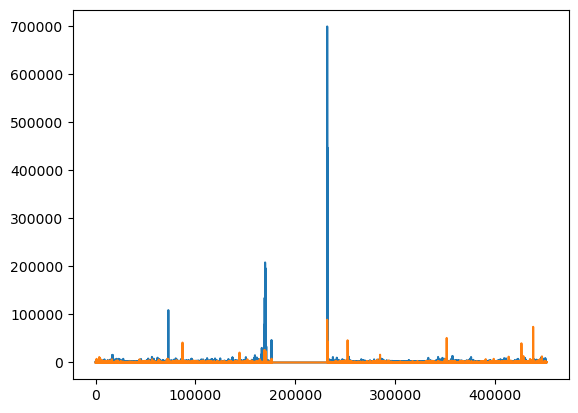

In [12]:
plt.plot(np.arange(len(h3k9me3_signal_nuc)), h3k9me3_signal_nuc, label = "h3k9me3")

plt.plot(np.arange(len(h3k27me3_signal_nuc)), h3k27me3_signal_nuc, label = "h3k27me3")

In [13]:
num_nucs = len(h3k9me3_signal_nuc)

one_mark_cutoff = 220
two_mark_cutoff = one_mark_cutoff*2
print("# NO mark nucs: ", np.sum(h3k9me3_signal_nuc<one_mark_cutoff))
print("# one mark nucs: ", np.sum(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)))
print("# two mark nucs: ", np.sum(h3k9me3_signal_nuc>=two_mark_cutoff))

# np.sum(h3k9me3_signal_nuc>=two_mark_cutoff)

# NO mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


In [14]:
num_nucs_27 = len(h3k27me3_signal_nuc)

one_mark_cutoff_27 = 220
two_mark_cutoff_27 = one_mark_cutoff_27*2
print("# NO mark nucs: ", np.sum(h3k27me3_signal_nuc<one_mark_cutoff_27))
print("# one mark nucs: ", np.sum(1*(h3k27me3_signal_nuc>=one_mark_cutoff_27) * 1*(h3k27me3_signal_nuc<two_mark_cutoff_27)))
print("# two mark nucs: ", np.sum(h3k27me3_signal_nuc>=two_mark_cutoff_27))

# np.sum(h3k9me3_signal_nuc>=two_mark_cutoff)

# NO mark nucs:  269612
# one mark nucs:  97229
# two mark nucs:  84633


In [15]:
num_nucs_27

451474

In [16]:
num_nucs

451470

In [17]:
# 1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)

In [18]:
marks_1 = np.zeros(num_nucs)

marks_1[np.where(h3k9me3_signal_nuc<one_mark_cutoff)] = 0
marks_1[np.where(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff))] = 1
marks_1[np.where(h3k9me3_signal_nuc>=two_mark_cutoff)] = 2


marks_2 = np.zeros(num_nucs_27)

marks_2[np.where(h3k27me3_signal_nuc<one_mark_cutoff_27)] = 0
marks_2[np.where(1*(h3k27me3_signal_nuc>=one_mark_cutoff_27) * 1*(h3k27me3_signal_nuc<two_mark_cutoff_27))] = 1
marks_2[np.where(h3k27me3_signal_nuc>=two_mark_cutoff_27)] = 2

marks_2 = marks_2[:num_nucs] # make mark profiles same length

In [19]:
len(marks_1)

451470

In [20]:
len(marks_2)

451470

In [22]:
print("# zero mark1 nucs: ", np.sum(marks_1==0))
print("# one mark1 nucs: ",  np.sum(marks_1==1))
print("# two mark1 nucs: ", np.sum(marks_1==2))


print("# zero mark2 nucs: ", np.sum(marks_2==0))
print("# one mark2 nucs: ",  np.sum(marks_2==1))
print("# two mark2 nucs: ", np.sum(marks_2==2))


# zero mark1 nucs:  189916
# one mark1 nucs:  99726
# two mark1 nucs:  161828
# zero mark2 nucs:  269612
# one mark2 nucs:  97227
# two mark2 nucs:  84631


In [24]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# plt.plot(np.arange(len(marks_1)), marks_1, linewidth = 0.01)
# plt.scatter(np.arange(len(marks_1)), marks_1)

# plt.plot(np.arange(len(marks_2)), marks_2, linewidth = 0.01)
# plt.scatter(np.arange(len(marks_2)), marks_2)

# plt.xlabel("nucleosome i")
# plt.ylabel(r"$\sigma_i^{(1)}$")

# 2) HP1, PRC1 binding profile

implemented a binding model that considers looping behavior (or just self-interaction due to configuration) of chromosome, as opposed to old binding model which does not consider the impact of looping on the interaction (mean field only). Notes on theory in gmail, title "9/18 meeting binding model with looping"

competitive binding model

In [86]:
def calc_s_bind_comp(ws, mus, f_binds):
    f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11 = f_binds
    mu_1, mu_2 = mus
    # sigma1, sigma2 = sigmas
    w_1, w_2 = ws

    # boltzmann probability of each binding state [s_HP1, s_PRC1]
    p_00 = 1
    p_10 = np.exp(-f_bind_10 + mu_1*1 - w_1*1) 
    p_01 = np.exp(-f_bind_01 + mu_2*1 - w_2*1)
    p_20 = np.exp(-f_bind_20 + mu_1*2 - w_1*2)
    p_02 = np.exp(-f_bind_02 + mu_2*2 - w_2*2)
    p_11 = np.exp(-f_bind_10 + mu_1*1 - w_1*1  - f_bind_01 + mu_2*1 - w_2*1)
    
    q_bind = p_00 + p_01 + p_10 + p_02 + p_20 + p_11 #1. + np.exp(-eps * sigma + mu - w)
    s_bind1 = (1*p_10 + 2*p_20 + 1*p_11) / q_bind #(f_bind_20 + mu_1 - w_1) + 1*(f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind
    s_bind2 = (1*p_01 + 2*p_02 + 1*p_11) / q_bind #np.exp(1*(f_bind_01 + mu_2 - w_2) + 2*(f_bind_02 + mu_2 - w_2) + 1(*f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind

    s_binds = [s_bind1, s_bind2]
    return s_binds

# x: genomic distance
# a = 2.6065
# a = 2.6075, mu = -4.8, v_int = -2 : get bridging

def calc_p_loop(x, a=0.01):
    # gaussian looping
    p_loop = a / np.abs(x) ** (1.5)
    
    return p_loop

def calc_p_loop_nn(x):
    # neareast neighbor interactions only
    p_loop = np.zeros(len(x))
    p_loop[0] = 1
    return p_loop
    
def calc_p_loop_rubenstein(x, a=0.01):
    # nuclear enviroment looping. Following math of ms end to end multi-scale function
    bp_per_nuc = 190 # bp per nucleosome

    lower_cutoff = 28.89 * 1000 # bp, s1*, from Rubenstein
    upper_cutoff = 399.12 * 1000 # bp, s2*
    lw_cut_nuc = int(lower_cutoff/bp_per_nuc)
    up_cut_nuc = int(upper_cutoff/bp_per_nuc)

    #divide x into three parts 

    #below cutoffs
    index = x <= lw_cut_nuc
    x_lower = x[index]
    p_loop_lower = a / (np.abs(x_lower) ** (1.5))

    #between cutoffs
    index = (x > lw_cut_nuc) * ( x <= up_cut_nuc)
    x_inter = x[index]
    p_1 = p_loop_lower[-1]
    p_loop_inter = p_1 * ( np.abs(x_inter) / lw_cut_nuc)**(-0.75)
    # p_loop_inter = p_loop_lower[-1] + a / np.abs(x_inter) ** (0.75)
    # p_loop_inter = a / np.abs(x_inter) ** (0.75)
    # p_loop_inter -= (p_loop_inter[0] - p_loop_lower[-1])

    #above cutoffs
    index = x > up_cut_nuc
    x_upper = x[index]
    p_2 = p_loop_inter[-1]
    p_loop_upper = p_2 * (np.abs(x_upper)/up_cut_nuc)**(-1.5)

    
    return np.concatenate((p_loop_lower, p_loop_inter, p_loop_upper))
    # return p_loop

Text(0.5, 1.0, 'rubenstein nuclear looping')

<Figure size 640x480 with 0 Axes>

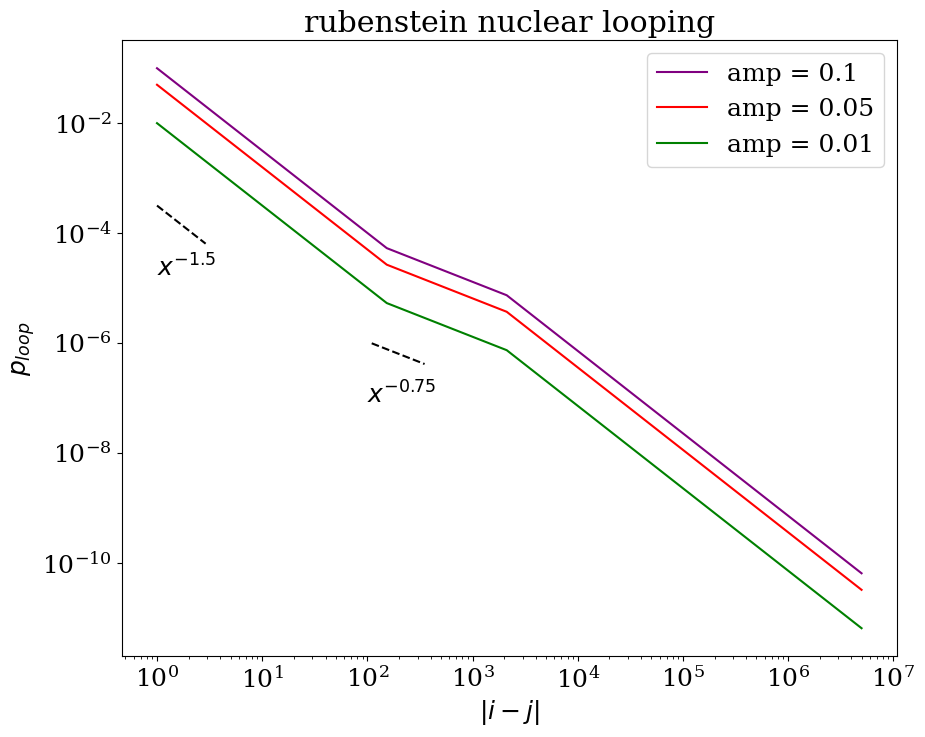

In [52]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=.1), label = "amp = 0.1", color = "purple")
plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=0.05), label = "amp = 0.05", color = "red")
plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=0.01), label = "amp = 0.01", color = "green")
plt.xlabel(r"$| i - j|$")
plt.ylabel(r"$p_{loop}$")

x = np.arange(10,30,1)
xx = np.arange(220000,700000,1)
plt.plot(x*0.1, 0.01*x**-1.5, linestyle = "--", color = "black")#, label = r"$x^{-1.5}$")
plt.plot(xx*0.0005, 0.01* xx**-.75, linestyle = "--", color = "black")#, label = r"$x^{-0.75}$")
plt.text(1,.0016*0.01, r"$x^{-1.5}$")
plt.text(100,.000008*0.01, r"$x^{-0.75}$")
plt.legend()
plt.title("rubenstein nuclear looping")


In [84]:
%%time
# 2 marks competitive, no for loop

v_int = np.array([[-4,0],[0,-4]])
mus = [-5,-100]
e_m = [1.52, 1.52]

# marks_2 = np.zeros(len(marks_1))

sigma_1 = marks_1
sigma_2 = marks_2
sigmas = [sigma_1, sigma_2]

n_nuc = len(sigma_1)
n_iter = 100

amp = 0.05 # contact rpobability constant
# e_m = [2, 2]
# v_int = np.array([[-2,0],[0,-2]])

w_1 = np.zeros(n_nuc)
w_2 = np.zeros(n_nuc)
ws = [w_1, w_2]
ws_old = np.copy(ws)

s_arr = np.copy(ws)

f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]

print("convergence:")
for i in range(n_iter):
    # convergence test
    if (i != 0 and (i%10 == 0)) or (i==1) or (i==n_iter-1):
        ws_1_conv = np.sum(np.abs(ws[0] - ws_old[0]))
        ws_2_conv = np.sum(np.abs(ws[1] - ws_old[1]))
        # print(np.abs(np.sum(ws[0] - ws_old[0])))
        # print(np.abs(np.sum(ws[1] - ws_old[1])))
        print(ws_1_conv + ws_2_conv)
        
    ws_old = np.copy(ws)
    s_old = np.copy(s_arr)
    
    s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # calcultae binding state of HP1 and PRC1
    # s = calc_s_bind(w, sigma, eps, mu)

    # calculate array of looping probabilitys by nucleosome, with padding for convolution
    k = 0
    p_loop_ini = np.concatenate((np.array([0]),calc_p_loop_nn(np.arange(k + 1, n_nuc)-k))) # nearest neighbor only
    # p_loop_ini = np.concatenate((np.array([0]),calc_p_loop_rubenstein(np.arange(k + 1, n_nuc)-k, amp)))
    # p_loop_ini = np.concatenate((np.array([0]),calc_p_loop(np.arange(k + 1, n_nuc)-k, amp))) # gaussian looping
    
    p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))

    # calculate part of interaction energy
    p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
    p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)

    # calculate mean-field protein conjugate field via saddle point equation
    w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
    w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1
    ws = [w_1_fast, w_2_fast]

# s_1, s_2 = s_arr

convergence:
35664.97920871557
0.013235913163988535
4.3235316750378505e-09
8.756637775997334e-12
8.612019083975575e-12
8.916289581661907e-12
8.740565562992408e-12
8.645034341170366e-12
8.723792521703189e-12
8.822990948953446e-12
8.871748821692726e-12
CPU times: total: 20.3 s
Wall time: 31.8 s


In [85]:
s_1, s_2 = s_arr

# factor = 36
# s_1_avgd = np.mean(s_1.reshape(-1, factor), axis=1)
# s_2_avgd = np.mean(s_2.reshape(-1, factor), axis=1)

# factor = 500
# s_1_avgd = np.mean(s_1[:(len(s_1)//factor)*factor].reshape(-1,factor), axis=1) 
# s_2_avgd = np.mean(s_2[:(len(s_2)//factor)*factor].reshape(-1,factor), axis=1) 

In [86]:
np.mean(s_1)

0.011413379724187723

In [87]:
s_2

array([1.62705224e-44, 1.62704709e-44, 1.62704702e-44, ...,
       7.41819757e-44, 7.43908921e-44, 4.53314963e-44])

Text(0.5, 1.0, '$ \\mu = -5$')

<Figure size 640x480 with 0 Axes>

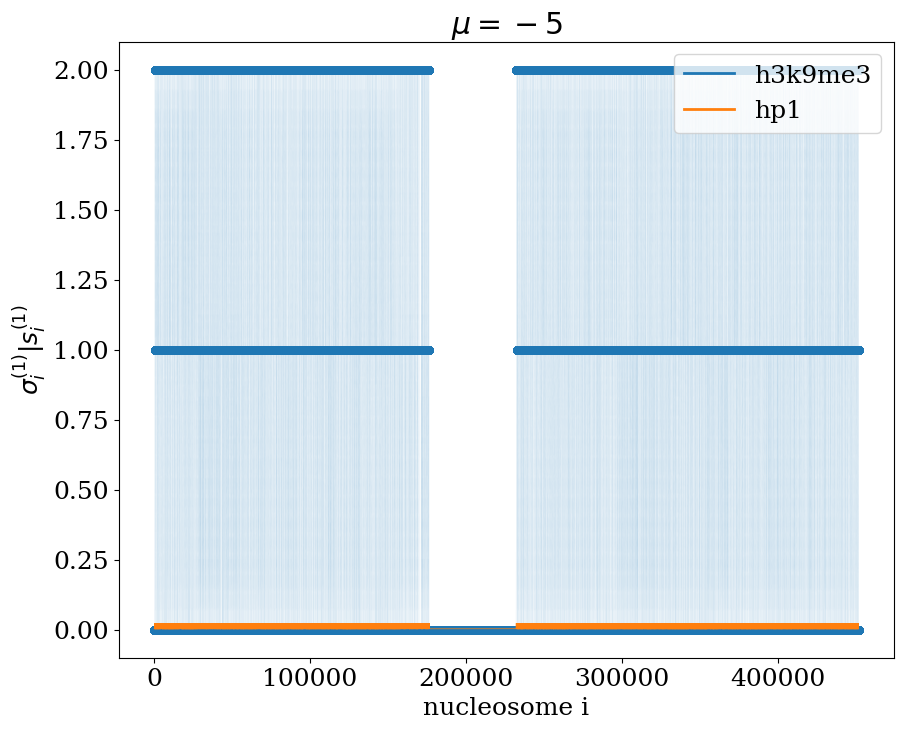

In [88]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(marks_1)), marks_1, linewidth = 0.01, label = "h3k9me3")
plt.scatter(np.arange(len(marks_1)), marks_1, linewidth = 0.01)
plt.plot(np.arange(len(marks_1)), s_1, linewidth = 0.5, label = "hp1")
plt.xlabel("nucleosome i")
plt.ylabel(r"$\sigma_i^{(1)} | s_i^{(1)}  $")
# plt.legend(linewidth = 1)

# get the legend object
leg = plt.legend(loc=1)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.title(r"$ \mu = %s$" % mus[0])

Text(0.5, 1.0, '$ \\mu = -100$')

<Figure size 640x480 with 0 Axes>

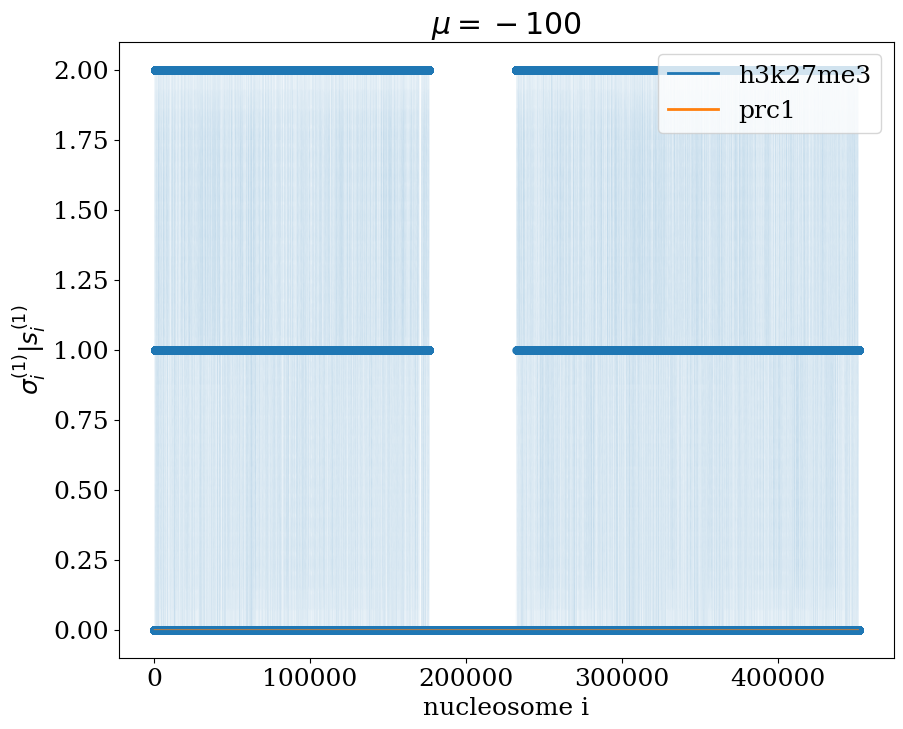

In [63]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(marks_2)), marks_2, linewidth = 0.01, label = "h3k27me3")
plt.scatter(np.arange(len(marks_2)), marks_2, linewidth = 0.01)
plt.plot(np.arange(len(marks_2)), s_2, linewidth = 0.5, label = "prc1")
plt.xlabel("nucleosome i")
plt.ylabel(r"$\sigma_i^{(1)} | s_i^{(1)}  $")
# plt.legend(linewidth = 1)

# get the legend object
leg = plt.legend(loc=1)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.title(r"$ \mu = %s$" % mus[1])

In [22]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.plot(np.arange(n_nuc//factor), s_1_avgd_noloop, alpha = 0.5, label = "no contact")
# plt.plot(np.arange(n_nuc//factor), s_1_avgd, alpha = 0.5, label = "rub contact")
# # plt.plot(np.arange(n_nuc//factor), s_1_avgd_chromo, alpha = 0.5, label = "chromo")
# plt.title("HP1 binding state" + "\n" \
#           + " a = %s, factor = %s, " % (amp, factor) + "\n" \
#           "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
# plt.xlabel("avgd nucleosome")
# plt.ylabel(r"$ \langle s \rangle$")
# plt.legend()

In [23]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.plot(np.arange(n_nuc//factor), s_2_avgd_noloop, alpha = 0.5, label = "no contact")
# plt.plot(np.arange(n_nuc//factor), s_2_avgd, alpha = 0.5, label = "rub contact")
# # plt.plot(np.arange(n_nuc//factor), s_2_avgd_chromo, alpha = 0.5, label = "chromo")

# plt.title("PRC1 binding state" + "\n" \
#           + " a = %s, factor = %s, " % (amp, factor) + "\n" \
#           "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
# plt.xlabel("avgd nucleosome")
# plt.ylabel(r"$ \langle s \rangle$")
# plt.legend()

# 3) Hi-C contact map

In [25]:
# Get normalized observed, then normalized expected then do O/E analysis

In [26]:
resolution = 1e6 #1mb
Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWobserved", sep="\t", header=None)
Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRnorm")
# Hi_c_raw_exp = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWexpected", sep="\t", header=None)
# Hi_c_raw_exp.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRexpected")

# resolution = 500e3 #500kb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_500kb.KRexpected")

# resolution = 100e3 #100kb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_100kb.KRexpected")

# resolution = 50e3 #50kb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_50kb.KRexpected")

# resolution = 5e3 #5kb
# Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.RAWobserved", sep="\t", header=None)
# Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
# Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.KRnorm")
# Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_5kb.KRexpected")

In [27]:
Hi_c_raw_obs#[r"$M_{ij}$"].values

,i,j,$M_{ij}$
0,0,0,427176.0
1,0,1000000,107415.0
2,1000000,1000000,431344.0
3,0,2000000,29197.0
4,1000000,2000000,82222.0
...,...,...,...
3316,86000000,90000000,1675.0
3317,87000000,90000000,3349.0
3318,88000000,90000000,6295.0
3319,89000000,90000000,34619.0


In [28]:
# (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // 1e6).astype(int)])
# Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // 1e6).astype(int)]

## KR normalization of observed Hi-C data

In [30]:
# Hi_c_KRnorm#.values

In [31]:
# Hi_c_Kr_obs = M_ij / (Hi_c_KRnorm[ i value int divide by 1e7]*Hi_c_KRnorm[ j value int divide by 1e7])

Hi_c_Kr_obs = Hi_c_raw_obs[r"$M_{ij}$"].values / (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // resolution).astype(int)]*Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // resolution).astype(int)])

In [32]:
Hi_c_Kr_obs

array([442732.35437198, 104734.43314127, 395674.85574671, ...,
        19347.5726569 ,  88154.06351783, 508568.61140395])

In [33]:
Hi_c_raw_obs[r"$M_{ij}^{KR}$"] = Hi_c_Kr_obs

## Obs/Exp

In [35]:
# observed/expected correction
i_j_diff = Hi_c_raw_obs["i"].values - Hi_c_raw_obs["j"].values
Kr_indices = (i_j_diff // resolution).astype(int)
Hi_c_Kr_OE = Hi_c_Kr_obs / Hi_c_KRexpected[Kr_indices]

In [36]:
Hi_c_Kr_OE

array([  1.52154513, 116.37401554,   1.35982189, ...,  27.05379845,
        97.95099902,   1.74780561])

In [37]:
Hi_c_raw_obs[r"$(O/E)^{KR}$"] = Hi_c_Kr_OE

In [38]:
Hi_c_raw_obs

,i,j,$M_{ij}$,$M_{ij}^{KR}$,$(O/E)^{KR}$
0,0,0,427176.0,442732.354372,1.521545
1,0,1000000,107415.0,104734.433141,116.374016
2,1000000,1000000,431344.0,395674.855747,1.359822
3,0,2000000,29197.0,29398.647419,41.108262
4,1000000,2000000,82222.0,77887.415663,86.543375
...,...,...,...,...,...
3316,86000000,90000000,1675.0,4492.213135,7.950041
3317,87000000,90000000,3349.0,8762.988778,14.198594
3318,88000000,90000000,6295.0,19347.572657,27.053798
3319,89000000,90000000,34619.0,88154.063518,97.950999


## plotting

<Figure size 640x480 with 0 Axes>

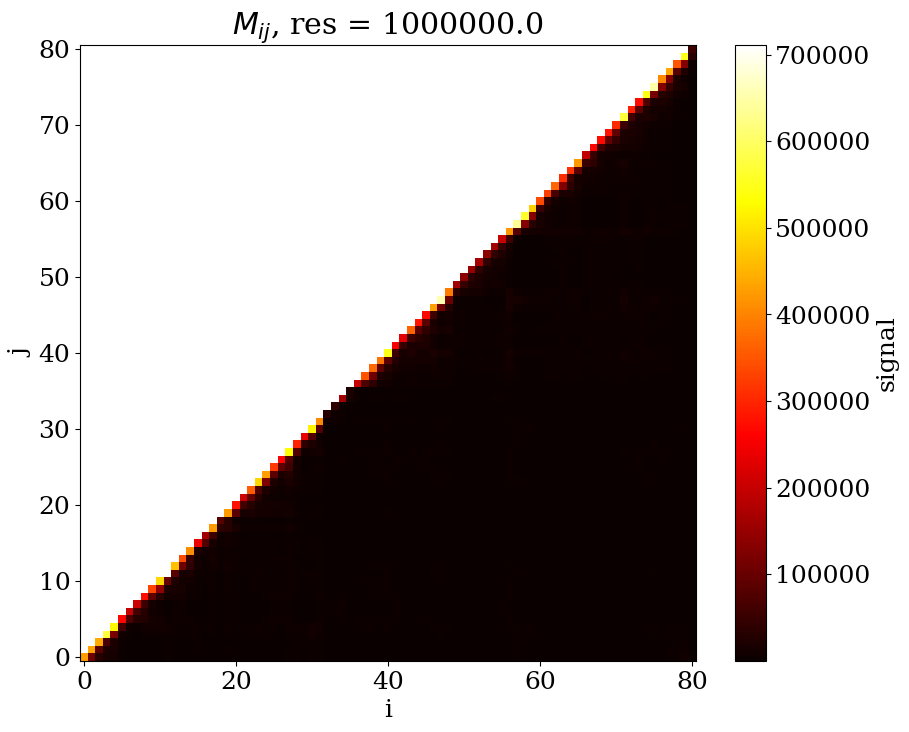

In [40]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

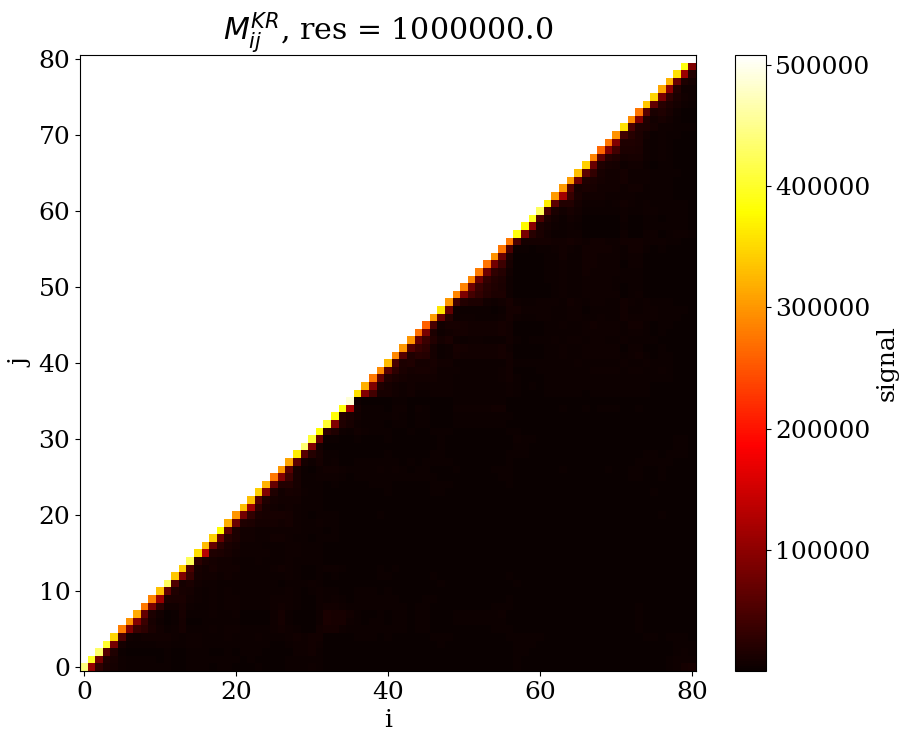

In [41]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}^{KR}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}^{KR}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

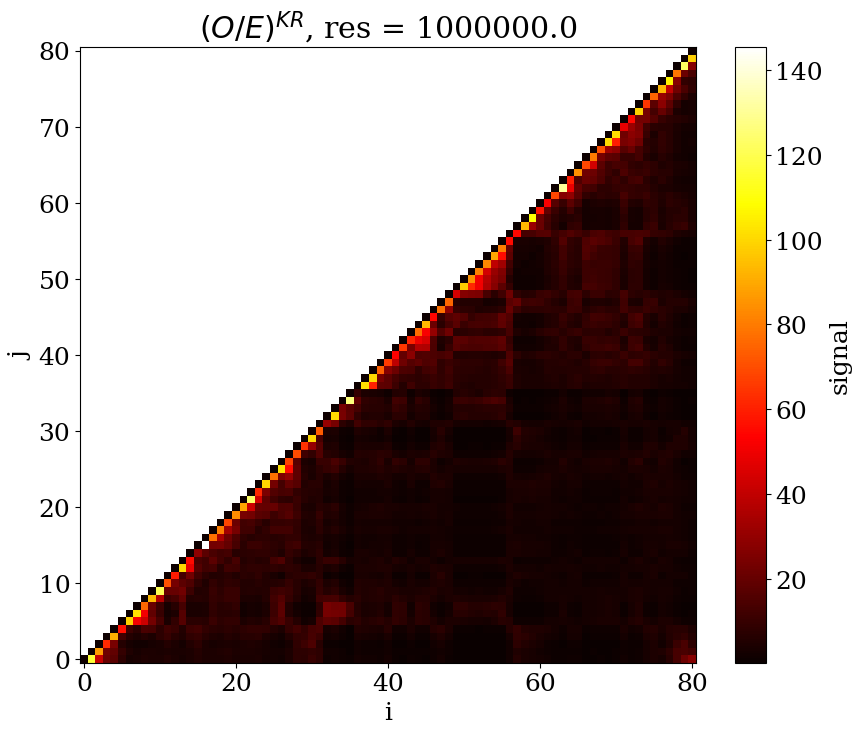

In [42]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r"$(O/E)^{KR}$")

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap="hot", interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r"$(O/E)^{KR}$, res = %s" % resolution)

# Show the plot
plt.show()

# 4) Neural Net

In [44]:
Hi_c_raw_obs

,i,j,$M_{ij}$,$M_{ij}^{KR}$,$(O/E)^{KR}$
0,0,0,427176.0,442732.354372,1.521545
1,0,1000000,107415.0,104734.433141,116.374016
2,1000000,1000000,431344.0,395674.855747,1.359822
3,0,2000000,29197.0,29398.647419,41.108262
4,1000000,2000000,82222.0,77887.415663,86.543375
...,...,...,...,...,...
3316,86000000,90000000,1675.0,4492.213135,7.950041
3317,87000000,90000000,3349.0,8762.988778,14.198594
3318,88000000,90000000,6295.0,19347.572657,27.053798
3319,89000000,90000000,34619.0,88154.063518,97.950999


In [45]:
# arrange in matrix of vars, final column of hi-c map values

In [46]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron 
import itertools

In [47]:
# data columns:
# {section 1 nucleosome indices} {section 1 binding states OR mark profiles} {section 2 nuc ind} {sec 2 bind or mark} {Hi-C val}
nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

In [48]:
nuc_per_bin

5000

In [49]:
resolution

1000000.0

## mark-Hi-C data set

In [51]:
# #TEST simple example
# binning_TEST = 2 # nuc per bin
# marks_1_TEST = np.array([2,1,0,1,1,2])
# marks_1_ind_TEST = np.arange(6)
# mlp_data_markind = marks_1_ind_TEST[:(len(marks_1_ind_TEST)//binning_TEST)*binning_TEST].reshape(-1,binning_TEST)
# mlp_data_mark = marks_1_TEST[:(len(marks_1_TEST)//binning_TEST)*binning_TEST].reshape(-1,binning_TEST)
# mlp_half_data = np.append(mlp_data_markind, mlp_data_mark, axis = 1) #
# # tODO  all possible pairings
# # find all combinations of chrmomose sections, then append appropriate row?

# # 12, 13, 23
# print("mlp_half:", mlp_half_data)#[0] # get 0 row
# num_groups = len(mlp_data_markind)
# # need_combs_array = np.arange(num_groups) #array from which pair combinations need to be made from

# all_combs = np.array(list(itertools.combinations(range(num_groups), 2)))
# num_combs = len(all_combs)
# num_cols = (binning_TEST)*4
# final_mlp = np.zeros((num_combs, num_cols+1)) #+1 for hi-c data
# for i,comb in enumerate(all_combs):
#     # i = #comb[0] + comb[1] - 1
#     print(np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]))
#     final_mlp[i, 0:num_cols] = np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]) # final matrix without hi-c
#     # final_mlp[i, num_cols] = Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"].values[0]

In [52]:
# # TEST fast
# i_combs = [1,2,3]Hi_c_raw_obs_div["i"].values
# j_combs = Hi_c_raw_obs_div["j"].values
# Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

# # make all_combs equiv from i adnd j combs arr
# all_combs_fast = np.vstack((i_combs, j_combs)).T
# final_mlp_fast = mlp_half_data[all_combs_fast].reshape((num_combs, num_cols))
# final_mlp_fast = np.hstack((final_mlp_fast, Hi_C))
# final_mlp_fast

In [53]:
# %%time
# # SLOW
# marks_1_ind = np.arange(len(marks_1))

# # first divide data into bins
# mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
# mlp_data_mark = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

# #combine genomic position and mark data; half of the data needed for mlp
# mlp_half_data = np.append(mlp_data_markind, mlp_data_mark, axis = 1) #


# # now must find all combinations of chromosome bins

# num_bins = len(mlp_data_markind)
# all_combs = np.array(list(itertools.combinations_with_replacement(range(num_bins), 2))) # all possible pairs of bins, including self interaction
# num_combs = len(all_combs)
# num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins

# mark_mlp_data = np.zeros((num_combs, num_cols+1)) # +1 for hi-c data

# # generate copy of Hi-c data where genomic position turned into {bin index precursor}
# Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
# Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs["i"].values//resolution).astype(int)
# Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs["j"].values//resolution).astype(int)

# non_zero_vals_i = np.unique((Hi_c_raw_obs["i"].values//resolution).astype(int)) # only looking at indices where some contact reported
# non_zero_vals_j = np.unique((Hi_c_raw_obs["j"].values//resolution).astype(int))

# num_weird = 0 #number of combinations that dont appear in Hi-C data
# for i,comb in enumerate(all_combs):
#     # print(comb)
#     if comb[0] in non_zero_vals_i and comb[1] in non_zero_vals_j:
#     # print(np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]))
#         mark_mlp_data[i, 0:num_cols] = np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]) # final matrix without hi-c
#         # find hi-c value that corresponds to current region combination
#         if len(Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"]) != 0:
#             mark_mlp_data[i, num_cols] = Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"].values[0]
#         else:
#             num_weird += 1

In [54]:
%%time

# FAST!!
marks_1_ind = np.arange(len(marks_1))

# first divide mark data into bins
mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
mlp_data_mark = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

#combine genomic position and mark data; half of the data needed for mlp
mlp_half_data = np.append(mlp_data_markind, mlp_data_mark, axis = 1) #

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1_ind)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

# make matrix of all Hi-C bin index combinations
all_combs_fast = np.vstack((i_combs, j_combs)).T

#get all mark data that corresponds to bin in Hi-C data
num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins
mark_mlp_data_fast = mlp_half_data[all_combs_fast].reshape((len(all_combs_fast), num_cols)) 

# attach corresponding Hi-C value
mark_mlp_data_fast = np.hstack((mark_mlp_data_fast, np.zeros((len(all_combs_fast),1))))#(Hi_C))
mark_mlp_data_fast[:,-1] = Hi_C

CPU times: total: 188 ms
Wall time: 736 ms


In [55]:
# columns:
# {section 1 nucleosome indices} {section 1 binding states OR mark profiles} {section 2 nuc ind} {sec 2 bind or mark} {Hi-C val}
# np.shape(mark_mlp_data)
np.shape(mark_mlp_data_fast)

(3240, 20001)

## binding-state-Hi-C data set

In [57]:
# %%time
# #SLOW
# marks_1_ind = np.arange(len(marks_1))

# # first divide data into bins
# mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
# mlp_data_bind = s_1[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

# #combine genomic position and mark data; half of the data needed for mlp
# mlp_half_data = np.append(mlp_data_markind, mlp_data_bind, axis = 1) #


# # now must find all combinations of chromosome bins

# num_bins = len(mlp_data_markind)
# all_combs = np.array(list(itertools.combinations_with_replacement(range(num_bins), 2))) # all possible pairs of bins, including self interaction
# num_combs = len(all_combs)
# num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins

# bind_mlp_data = np.zeros((num_combs, num_cols+1)) # +1 for hi-c data

# # generate copy of Hi-c data where genomic position turned into {bin index precursor}
# Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
# Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs["i"].values//resolution).astype(int)
# Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs["j"].values//resolution).astype(int)

# non_zero_vals = np.unique((Hi_c_raw_obs["i"].values//1e6))
# for i,comb in enumerate(all_combs):
#     # print(comb)
#     if comb[0] in non_zero_vals and comb[1] in non_zero_vals:
#     # print(np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]))
#         bind_mlp_data[i, 0:num_cols] = np.append(mlp_half_data[comb[0]], mlp_half_data[comb[1]]) # final matrix without hi-c
#         # find hi-c value that corresponds to current region combination
#         bind_mlp_data[i, num_cols] = Hi_c_raw_obs_div.query("i==%s & j==%s" % (comb[0], comb[1]))[r"$(O/E)^{KR}$"].values[0] 

In [58]:
%%time

# FAST!!
marks_1_ind = np.arange(len(marks_1))

# first divide data into bins
mlp_data_markind = marks_1_ind[:(len(marks_1_ind)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)
mlp_data_bind = s_1[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)

#combine genomic position and mark data; half of the data needed for mlp
mlp_half_data = np.append(mlp_data_markind, mlp_data_bind, axis = 1) #

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1_ind)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

# make matrix of all Hi-C bin index combinations
all_combs_fast = np.vstack((i_combs, j_combs)).T

#get all mark data that corresponds to bin in Hi-C data
num_cols = (nuc_per_bin)*4 # the genomic positions and mark profiles of both bins
bind_mlp_data_fast = mlp_half_data[all_combs_fast].reshape((len(all_combs_fast), num_cols)) 

# attach corresponding Hi-C value
bind_mlp_data_fast = np.hstack((bind_mlp_data_fast, np.zeros((len(all_combs_fast),1))))#(Hi_C))
bind_mlp_data_fast[:,-1] = Hi_C

CPU times: total: 250 ms
Wall time: 702 ms


In [59]:
# columns:
# {section 1 nucleosome indices} {section 1 binding states OR mark profiles} {section 2 nuc ind} {sec 2 bind or mark} {Hi-C val}
print(resolution)
np.shape(bind_mlp_data_fast)

1000000.0


(3240, 20001)

## Train neural net

### single layer perceptron

#### mark data

In [63]:
%%time

data = mark_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_mark, X_test_mark, y_train_mark, y_test_mark = train_test_split(X,y,random_state=1, test_size=0.2)
#train model
mark_SLP_reg = MLPRegressor(hidden_layer_sizes=(100),activation="relu",random_state=1).fit(X_train_mark, y_train_mark)

y_pred=mark_SLP_reg.predict(X_test_mark)

print("resolution = %s" % resolution) 
print("training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
print("testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))

C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


resolution = 1000000.0
training score: -0.3430482607216636
testing score: -0.33816465967170894
CPU times: total: 3.59 s
Wall time: 3.19 s


In [64]:
# %%time

# data = mark_mlp_data
# X = data[:,0:-1]
# y = data[:,-1]

# X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size=0.2)
# #train model
# mark_SLP_reg = Perceptron(random_state=1).fit(X_train, y_train) # ONLY FOR CLASSIFICATION

# y_pred=mark_SLP_reg.predict(X_test)

# print("training score:", mark_SLP_reg.score(X_train, y_train))
# print("testing score:", mark_SLP_reg.score(X_test, y_test))a

#### binding data

In [66]:
%%time

data = bind_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(X,y,random_state=1, test_size=0.2)
#train model
bind_SLP_reg = MLPRegressor(hidden_layer_sizes=(100),activation="relu",random_state=1).fit(X_train_bind, y_train_bind)

y_pred=bind_SLP_reg.predict(X_test_bind)

print("training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
print("testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))

C:\Users\tmhab\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


training score: -219535367.05739465
testing score: -208090597.26906452
CPU times: total: 906 ms
Wall time: 612 ms


In [67]:
print("resolution = %s" % resolution)
print("MARK training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
print("MARK testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))
print("BIND training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
print("BIND testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))

resolution = 1000000.0



KeyboardInterrupt



In [ ]:
y[0:10]

In [ ]:
y_pred[0:10]

In [ ]:
#bind_mlp_data, mark_mlp_data

# 5) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## mark model

In [ ]:
%%time

data = mark_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_mark, X_test_mark, y_train_mark, y_test_mark = train_test_split(X,y,random_state=1, test_size=0.2)

# Fitting Random Forest Regression to the dataset
RFreg_mark = RandomForestRegressor(n_estimators=10, random_state=1, oob_score=True).fit(X_train_mark, y_train_mark)

## bind model

In [ ]:
%%time

data = bind_mlp_data_fast
X = data[:,0:-1]
y = data[:,-1]

X_train_bind, X_test_bind, y_train_bind, y_test_bind = train_test_split(X,y,random_state=1, test_size=0.2)

# Fitting Random Forest Regression to the dataset
RFreg_bind = RandomForestRegressor(n_estimators=10, random_state=1, oob_score=True).fit(X_train_bind, y_train_bind)

## comparisons

In [ ]:
mark_train_preds = RFreg_mark.predict(X_train_mark)
mark_test_preds = RFreg_mark.predict(X_test_mark)

bind_train_preds = RFreg_bind.predict(X_train_bind)
bind_test_preds = RFreg_bind.predict(X_test_bind)

# Evaluating the model
# mse = mean_squared_error(y, predictions)
# print(f'Mean Squared Error: {mse}')

r2_train_mark = r2_score(y_train_mark, mark_train_preds)
r2_test_mark = r2_score(y_test_mark, mark_test_preds)

r2_train_bind = r2_score(y_train_bind, bind_train_preds)
r2_test_bind = r2_score(y_test_bind, bind_test_preds)

print("Random forest")
print("resolution = %s" % resolution)
print("MARK training score:", mark_SLP_reg.score(X_train_mark, y_train_mark))
print("MARK testing score:", mark_SLP_reg.score(X_test_mark, y_test_mark))
print("BIND training score:", bind_SLP_reg.score(X_train_bind, y_train_bind))
print("BIND testing score:", bind_SLP_reg.score(X_test_bind, y_test_bind))


# 6) General classification cost function minimization

Can define a cost function $J = \sum_{ij} (s_{ij} - f_{ij})^2$ where $s_{ij}$ is the true Hi-C observation for the ijth bin and $f_{ij}$ is the output of the activation function (sigmoid) for the same bin. 
$f_{ij}(b_{ij}) = \frac{1}{1+\exp(-b_{ij})}$ is a function of the ijth mark array $b_{ij} = \vec{\sigma}_i \mathbf{A} \vec{\sigma}_j + A_0$, where $\sigma_i$ is the mark profile vector and $\mathbf{A}$ is a matrix and $A_0$ is a scalar, both of which need to be "learned".

10/24 EDIT:  $\sigma_i$ is the mark profile vector, as in each entry is the averaged mark content for a specific mark type [h3k9me3, h3k27me3, ...]

In [44]:
# faster einsum
def func_dot_einsum(A, sig_i, sig_j):
    Y = sig_i.dot(A)
    return np.einsum('ij,ij->i', Y, sig_j)

# A_0 = 0
# WHERE sigma is array of averaged mark 
def cost_function(As, params):
    # num_marks = 1
    [sig_i_avgd, sig_j_avgd, s_ij, num_marks] = params
    # num_marks = np.shape(sig_i_avgd)[1]
    # sig_i_avgd = np.mean(sig_i, axis=1)
    # sig_j_avgd = np.mean(sig_j, axis=1)
    
    A_0 = As[-1]
    A_mat = As[0:len(As)-1].reshape(num_marks, num_marks)
    
    # b_ij = np.diag(np.matmul(np.matmul(sig_i, A_mat),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j being 2D, USELESS
    # b_ij = np.sum(np.matmul(sig_i, A_mat) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation, USELESS
    # b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat, sig_j) + A_0 # low mem, GOOD FOR 5kb
    # b_ij = func_dot_einsum(A_mat, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

    if num_marks == 1:
        # sig_i_avgd = sig_i_avgd_1
        # sig_j_avgd = sig_j_avgd_1
        b_ij = sig_i_avgd*A_mat[0]*sig_j_avgd+A_0
        # print(b_ij)
    else:
        A_mat[1,0] = A_mat[0,1] #enforce symmetry

        # sig_i_avgd =  np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
        # sig_j_avgd =  np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T
        
        # b_ij = np.sum(np.matmul(sig_i_avgd.T, A_test) *sig_j_avgd.T, axis = 1) + A_0
        # b_ij = np.einsum("ij,jk,ik->i", sig_i_avgd, A_mat, sig_j_avgd) + A_0 # low mem, GOOD FOR 5kb
        b_ij = func_dot_einsum(A_mat, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

    f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

    J = np.sum((s_ij - f_ij)**2) 
    return J

def simulated_annealing(objective, params, bounds, n_iterations, step_size, temp):
     # generate an initial point
     best = bounds#bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
     # evaluate the initial point
     best_eval = objective(best, params)
     # current working solution
     curr, curr_eval = best, best_eval
     # run the algorithm
     for i in range(n_iterations):
         # take a step
         cur_step = step_size/np.log(i+np.e) # decreasing step_size at iterations increase
         candidate = curr + np.random.randn(len(bounds)) * cur_step#step_size
         candidate_eval = objective(candidate, params)
         
         # check for new best solution
         if candidate_eval < best_eval:
             # store new best point
             best, best_eval = candidate, candidate_eval
             # report progress
             print('>%d f() = %.5f' % (i, best_eval))
             
         # difference between candidate and current point evaluation
         diff = candidate_eval - curr_eval
         # calculate temperature for current epoch
         # t = temp / float(i + 1) #linear
         t = temp/np.log(i+np.e) #log
         
         # calculate metropolis acceptance criterion
         metropolis = np.exp(-diff / t)
         # check if we should keep the new point
         if diff < 0 or np.random.rand() < metropolis:
             # store the new current point
             curr, curr_eval = candidate, candidate_eval
             
     return [best, best_eval]

## MARKS

In [430]:
nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that mark data and hi-c data are same size
cutoff_bin = len(marks_1)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

#Turn Hi_C data into binary classification; 1 = contact, 0 = no
s_ij = np.zeros(len(Hi_C))
s_ij[Hi_C > np.mean(Hi_C)] = 1 # Hi_C into binary classification, based on MEDIAN

# first divide mark data into bins
mlp_data_mark_1 = marks_1[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)

#get all mark data that corresponds to bin in Hi-C data
sig_i = mlp_data_mark_1[i_combs] # matrix where each row is the section of mark profile
sig_j = mlp_data_mark_1[j_combs]

# get average mark signal for each bin
sig_i_avgd_1 = np.mean(sig_i, axis=1)
sig_j_avgd_1 = np.mean(sig_j, axis=1)
# num_marks = 1

# Do the same for mark_2
mlp_data_mark_2 = marks_2[:(len(marks_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)
sig_i_2 = mlp_data_mark_2[i_combs] # matrix where each row is the section of mark profile
sig_j_2 = mlp_data_mark_2[j_combs]
sig_i_avgd_2 = np.mean(sig_i_2, axis=1)
sig_j_avgd_2 = np.mean(sig_j_2, axis=1)
num_marks = 2

# calculate b_ij. should a 1d vector len = len(Hi-C) Old def of sigma
# b_ij = np.diag(np.matmul(np.matmul(sig_i, A),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j beind 2D
# b_ij = np.sum(np.matmul(sig_i, A) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation
# b_ij = np.einsum("ij,jk,ik->i", sig_i, A, sig_j) + A_0 # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
# b_ij = func_dot_einsum(A, sig_i, sig_j) # faster hybrid of einsum, again memory issue

# calc b_ij. CORRECT DEF OF SIGMA

#single A matrix to describe all pairs

A = np.zeros((num_marks, num_marks))
A_0 = 0

if num_marks == 1:
    sig_i_avgd = sig_i_avgd_1
    sig_j_avgd = sig_j_avgd_1
    b_ij = sig_i_avgd*A[0]*sig_j_avgd+A_0
    # print(b_ij)
else:
    sig_i_avgd =  np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
    sig_j_avgd =  np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T
    
    # b_ij = np.sum(np.matmul(sig_i_avgd.T, A_test) *sig_j_avgd.T, axis = 1) + A_0
    b_ij = np.einsum("ij,jk,ik->i", sig_i_avgd, A, sig_j_avgd) + A_0 # smpelst way
    # b_ij = func_dot_einsum(A, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue

f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

J = np.sum((s_ij - f_ij)**2) # cost function. could instead do maximum likelihood approach

In [432]:
# # MAT MUL TESTS
# a = np.array([[4,3,5],[1,1,2]])
# b = np.array([[6,3,2],[5,7,7]])

# A = np.array([[1,2,1],[5,1,8], [8,9,1]])

# np.matmul(np.matmul(a[0], A), b[0]) # works correctly

# print(np.matmul(a, A))
# print(b.T)
# print(np.diag(np.matmul(np.matmul(a, A),b.T)))
# np.matmul(np.matmul(a, A),b.T)

# np.sum(np.matmul(a, A) * b, axis=1) #alt way

# np.einsum("ij,jk,ik->i", a, A, b) # smpelst way



# # 2 mark types, 3 bins
# sig_1i = [4,5,6]
# sig_2i = [2,1,1]

# sig_1j = [0,2,1]
# sig_2j = [1,5,3]

# A_test = np.ones((2,2))
# sig_i = np.vstack((sig_1i, sig_2i)).T
# sig_j = np.vstack((sig_1j, sig_2j)).T

# print(sig_i.T)
# print(np.sum(np.matmul(sig_i, A_test) *sig_j, axis = 1))

# np.einsum("ij,jk,ik->i", sig_i, A_test, sig_j) # smpelst way

In [434]:
# b_ij_old = np.sum(np.matmul(sig_i, A) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation
# print("old done")
# # b_ij = np.einsum("ij,jk,ik->i", sig_i, A, sig_j) + A_0 # simplest way
# b_ij = func_dot_einsum(A, sig_i, sig_j)
# np.sum(b_ij == b_ij_old )/ len(b_ij)

### scipy.optimize minimization

In [437]:
# # A_0 = 0
# # WHERE sigma is array of marks of a single type
# def cost_function_OLD(As, params):
#     [sig_i, sig_j, s_ij] = params
#     A_0 = As[-1]
#     # print(np.shape(A))
#     A_mat = As[0:len(As)-1].reshape(nuc_per_bin, nuc_per_bin)
#     # b_ij = np.diag(np.matmul(np.matmul(sig_i, A_mat),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j being 2D, USELESS
#     # b_ij = np.sum(np.matmul(sig_i, A_mat) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation, USELESS
#     # b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat, sig_j) + A_0 # low mem, GOOD FOR 5kb
#     b_ij = func_dot_einsum(A_mat, sig_i, sig_j) + A_0 # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE
    
#     f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

#     J = np.sum((s_ij - f_ij)**2) 
#     return J

In [303]:
# a_ma = np.zeros((2,2))
# a_ma[0,1] = 4
# a_ma[1,0] = a_ma[0,1]
# a_ma

array([[0., 4.],
       [4., 0.]])

In [305]:
# # A_0 = 0
# # WHERE sigma is array of averaged mark 
# def cost_function(As, params):
#     # num_marks = 1
#     [sig_i_avgd, sig_j_avgd, s_ij, num_marks] = params
#     # num_marks = np.shape(sig_i_avgd)[1]
#     # sig_i_avgd = np.mean(sig_i, axis=1)
#     # sig_j_avgd = np.mean(sig_j, axis=1)
    
#     A_0 = As[-1]
#     A_mat = As[0:len(As)-1].reshape(num_marks, num_marks)
    
#     # b_ij = np.diag(np.matmul(np.matmul(sig_i, A_mat),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j being 2D, USELESS
#     # b_ij = np.sum(np.matmul(sig_i, A_mat) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation, USELESS
#     # b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat, sig_j) + A_0 # low mem, GOOD FOR 5kb
#     # b_ij = func_dot_einsum(A_mat, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

#     if num_marks == 1:
#         # sig_i_avgd = sig_i_avgd_1
#         # sig_j_avgd = sig_j_avgd_1
#         b_ij = sig_i_avgd*A_mat[0]*sig_j_avgd+A_0
#         # print(b_ij)
#     else:
#         A_mat[1,0] = A_mat[0,1] #enforce symmetry

#         # sig_i_avgd =  np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
#         # sig_j_avgd =  np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T
        
#         # b_ij = np.sum(np.matmul(sig_i_avgd.T, A_test) *sig_j_avgd.T, axis = 1) + A_0
#         # b_ij = np.einsum("ij,jk,ik->i", sig_i_avgd, A_mat, sig_j_avgd) + A_0 # low mem, GOOD FOR 5kb
#         b_ij = func_dot_einsum(A_mat, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

#     f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

#     J = np.sum((s_ij - f_ij)**2) 
#     return J

In [307]:
%%time
# As = np.zeros(nuc_per_bin**2+1)#np.zeros((nuc_per_bin, nuc_per_bin))  # Initial guess.

# params = [sig_i, sig_j, s_ij]   
# from scipy import optimize
# res = optimize.basinhopping(cost_function, A, minimizer_kwargs={"args" : params}, disp=True) #weird memory failure
# print("starting minimization")
# basinhopping/minimize only works for 5kb resolution!
# res = optimize.minimize(cost_function, As, args = params) 



CPU times: total: 0 ns
Wall time: 0 ns


### simulated annealing

In [423]:
resolution

1000000.0

In [439]:
%%time
num_marks = 2
As = np.zeros(num_marks**2+1)#np.zeros((nuc_per_bin, nuc_per_bin))  # Initial guess.

if num_marks == 1:
    sig_i_avgd = sig_i_avgd_1
    sig_j_avgd = sig_j_avgd_1
else:
    sig_i_avgd = np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
    sig_j_avgd = np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T

# sig_i_avgd = np.mean(sig_i, axis=1)
# sig_j_avgd = np.mean(sig_j, axis=1)

params = [sig_i_avgd, sig_j_avgd, s_ij, num_marks]   
step_size = 10
n_iter = 100
temp = 1000000
best, best_eval = simulated_annealing(cost_function, params, As,n_iter,step_size,temp)

>4 f() = 803.24037
CPU times: total: 0 ns
Wall time: 11 ms


In [441]:
A_0_best = best[-1]
# print(np.shape(A))
A_mat_best = best[0:len(best)-1].reshape(num_marks, num_marks)

# b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat_best, sig_j) + A_0_best # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
# b_ij = func_dot_einsum(A_mat_best, sig_i, sig_j) + A_0_best # faster hybrid of einsum, again memory issue

if num_marks == 1:
    b_ij = (sig_i_avgd*A_mat_best[0]*sig_j_avgd)+A_0_best
    # print(b_ij)
else:
    A_mat_best[1,0] = A_mat_best[0,1] #symmetry

    # b_ij = np.einsum("ij,jk,ik->i", sig_i_avgd, A_mat_best, sig_j_avgd) + A_0_best # low mem, GOOD FOR 5kb
    b_ij = func_dot_einsum(A_mat_best, sig_i_avgd, sig_j_avgd) + A_0_best # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

classified = np.zeros(len(f_ij))
classified[f_ij > 0.5] = 1

SS_res = np.sum((s_ij - classified)**2)
SS_tot = np.sum((s_ij - np.mean(s_ij))**2)

R2 = 1 - (SS_res/SS_tot) # cost function. could instead do maximum likelihood approach
R2

-0.4207985918527313

### parameter search

In [457]:
n_iter_arr

array([  10000.,  100000., 1000000.])

In [479]:
%%time
num_marks = 2

# step_size_min = 1
# step_size_max = 1e4
# step_size_range = 1e3

# n_iter_min = int(1e5)
# n_iter_max = int(1e6)
# n_iter_range = int(1e5)

# temp_min = 1000
# temp_max = 4000
# temp_range = 1000

# step_size_arr = np.arange(step_size_min,step_size_max,step_size_range)
# n_iter_arr = np.arange(n_iter_min,n_iter_max,n_iter_range)
# temp_arr = np.arange(temp_min,temp_max,temp_range)

step_size_min = 1
step_size_max = 3
step_size_num = 3

n_iter_min = 4
n_iter_max = 6
n_iter_num = 3

temp_min = 1
temp_max = 3
temp_num = 3

step_size_arr = np.logspace(step_size_min,step_size_max,step_size_num)
n_iter_arr = np.logspace(n_iter_min,n_iter_max,n_iter_num, dtype = int)
temp_arr = np.logspace(temp_min,temp_max,temp_num)

As = np.zeros(num_marks**2+1)#np.zeros((nuc_per_bin, nuc_per_bin))  # Initial guess.

if num_marks == 1:
    sig_i_avgd = sig_i_avgd_1
    sig_j_avgd = sig_j_avgd_1
else:
    sig_i_avgd = np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
    sig_j_avgd = np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T

params = [sig_i_avgd, sig_j_avgd, s_ij, num_marks]

R2_arr = np.zeros((len(temp_arr), len(n_iter_arr),len(step_size_arr)))
for i,temp in enumerate(temp_arr):
    for j,n_iter in enumerate(n_iter_arr):
        for k,step_size in enumerate(step_size_arr):
            best, best_eval = simulated_annealing(cost_function, params, As,n_iter,step_size,temp)
# ----------------------------------------------------------
            A_0_best = best[-1]
            # print(np.shape(A))
            A_mat_best = best[0:len(best)-1].reshape(num_marks, num_marks)
            
            # b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat_best, sig_j) + A_0_best # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
            # b_ij = func_dot_einsum(A_mat_best, sig_i, sig_j) + A_0_best # faster hybrid of einsum, again memory issue
            
            if num_marks == 1:
                b_ij = (sig_i_avgd*A_mat_best[0]*sig_j_avgd)+A_0_best
                # print(b_ij)
            else:
                # pass
                A_mat_best[1,0] = A_mat_best[0,1] # enforce symmetry
                b_ij = func_dot_einsum(A_mat_best, sig_i_avgd, sig_j_avgd) + A_0_best # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

                # b_ij = (np.matmul(sig_i_avgd, A_mat_best) *  sig_j_avgd) + A_0_best # TEST!!!
            
            f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid
            
            classified = np.zeros(len(f_ij))
            classified[f_ij > 0.5] = 1
            
            SS_res = np.sum((s_ij - classified)**2)
            SS_tot = np.sum((s_ij - np.mean(s_ij))**2)
            
            R2 = 1 - (SS_res/SS_tot) # cost function. could instead do maximum likelihood approach
            R2_arr[i,j,k] = R2

            
            print("R2_saved: ", R2)

>2 f() = 803.92265
>10 f() = 798.69714
>15 f() = 798.59032
>192 f() = 798.46053
>196 f() = 795.27047
>277 f() = 794.19073
>301 f() = 792.22075
>310 f() = 789.79332
>392 f() = 789.49260
>418 f() = 787.93736
>435 f() = 787.67799
>437 f() = 786.13073
>438 f() = 785.89448
>452 f() = 784.38383
>453 f() = 781.08209
>477 f() = 777.11253
>506 f() = 774.02182
>514 f() = 771.08567
>604 f() = 769.68166
>619 f() = 769.63393
>632 f() = 769.57487
>664 f() = 767.85206
>733 f() = 766.79389
>791 f() = 763.21846
>807 f() = 762.26341
>820 f() = 747.55590
>862 f() = 740.15199
>865 f() = 737.23510
>867 f() = 715.53080
>883 f() = 709.01116
>888 f() = 693.26201
>897 f() = 692.97279
>906 f() = 677.76352
>963 f() = 676.01895
>1047 f() = 675.34207
>1064 f() = 671.91613
>1082 f() = 665.19351
>1168 f() = 660.17162
>1206 f() = 653.10842
>1209 f() = 641.34390
>1236 f() = 639.75796
>1262 f() = 630.29291
>1270 f() = 618.72103
>1455 f() = 613.99246
>1499 f() = 612.58118
>1513 f() = 597.88937
>2079 f() = 597.85094
>303

C:\Users\tmhab\AppData\Local\Temp\ipykernel_12944\889309159.py:38: RuntimeWarning: overflow encountered in exp
  f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid


>353 f() = 777.02761
>377 f() = 776.43760
R2_saved:  -0.2937353031504544
>0 f() = 807.00000
>711 f() = 806.00000
>713 f() = 803.05759
>715 f() = 798.00000
>721 f() = 797.99718
>724 f() = 785.00000
>762 f() = 785.00000
>774 f() = 784.12019
>852 f() = 783.99350
>853 f() = 780.93972
>946 f() = 780.25448
>2018 f() = 780.00001
>2160 f() = 780.00000
>2200 f() = 780.00000
>2278 f() = 780.00000
>2404 f() = 780.00000
>2838 f() = 780.00000
>4338 f() = 779.89467
>4498 f() = 779.00000


<timed exec>:69: RuntimeWarning: overflow encountered in exp


R2_saved:  -0.28548444024770925
>1 f() = 807.00000
>2 f() = 806.99814
>4 f() = 806.95845
>5 f() = 805.64241
>8 f() = 803.72875
>49 f() = 802.99020
>50 f() = 800.99040
>112 f() = 800.76626
>158 f() = 800.30324
>289 f() = 799.84939
>291 f() = 799.26689
>411 f() = 799.05984
>417 f() = 799.01734
>468 f() = 798.98094
>511 f() = 798.83611
>49056 f() = 798.74165
>49058 f() = 798.61137
>49059 f() = 798.49319
>49197 f() = 798.24199
>49199 f() = 798.13992
>49200 f() = 798.09620
>50882 f() = 797.95020
>50883 f() = 797.82976
>50887 f() = 797.67990
>50889 f() = 797.59868
>51475 f() = 797.32313
>51493 f() = 797.25380
>51586 f() = 797.23070
>51587 f() = 797.12644
>51718 f() = 797.06403
>51730 f() = 797.04056
>51749 f() = 797.02356
>51750 f() = 797.01870
>51764 f() = 797.01179
>51765 f() = 797.00548
>51777 f() = 797.00156
>51803 f() = 797.00093
>51805 f() = 797.00088
>51806 f() = 797.00064
>51808 f() = 797.00050
>51809 f() = 797.00044
>51880 f() = 797.00032
>51904 f() = 797.00030
>51914 f() = 796.9964

In [480]:
np.shape(R2_arr)

(3, 3, 3)

In [481]:
print(temp_arr,n_iter_arr,step_size_arr)

[  10.  100. 1000.] [  10000  100000 1000000] [  10.  100. 1000.]


In [482]:
R2_arr # 2 mark log scheds, log params

array([[[-0.31353737, -0.2937353 , -0.28548444],
        [-0.3118872 , -0.2821841 , -0.27063289],
        [-0.30198617, -0.27063289, -0.28053392]],

       [[-0.33168927, -0.28548444, -0.30693668],
        [-0.28713461, -0.30858686, -0.29043496],
        [-0.30858686, -0.28713461, -0.28878479]],

       [[-0.37954428, -0.29208513, -0.32508858],
        [-0.34489065, -0.28878479, -0.28383427],
        [-0.28878479, -0.28548444, -0.30363634]]])

In [462]:
R2_arr # 1 mark log scheds, log params

array([[[-0.33168927, -0.33168927, -0.31848789],
        [-0.33168927, -0.32178824, -0.31848789],
        [-0.33168927, -0.33168927, -0.33168927]],

       [[-0.33168927, -0.31848789, -0.31848789],
        [-0.5528124 , -0.32508858, -0.31848789],
        [-0.33168927, -0.31848789, -0.31848789]],

       [[-0.33168927, -0.33168927, -0.31848789],
        [-0.32343841, -0.31848789, -0.32013806],
        [-0.33168927, -0.31848789, -0.33168927]]])

In [341]:
R2_arr # 1 mark

array([[[-0.33168927, -0.33168927],
        [-0.33168927, -0.37954428],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927]],

       [[-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.32178824],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.44885153]],

       [[-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.33168927],
        [-0.33168927, -0.37459376],
        [-0.33168927, -0.32673875],
        [-0.33168927, -0.33168927]]])

In [323]:
R2_arr # 2 marks

array([[[-0.30858686, -0.33333945],
        [-0.30033599, -0.29208513],
        [-0.30858686, -0.37129341],
        [-0.29868582, -0.31353737],
        [-0.30693668, -0.29868582],
        [-0.33663979, -0.30033599],
        [-0.30858686, -0.30363634],
        [-0.30033599, -0.30528651],
        [-0.30528651, -0.30033599]],

       [[-0.30198617, -0.29208513],
        [-0.30528651, -0.28548444],
        [-0.30858686, -0.29703565],
        [-0.29868582, -0.36469272],
        [-0.30528651, -0.32673875],
        [-0.30693668, -0.27228306],
        [-0.30033599, -0.35644186],
        [-0.29868582, -0.30363634],
        [-0.30528651, -0.30528651]],

       [[-0.30858686, -0.30198617],
        [-0.30033599, -0.28713461],
        [-0.30858686, -0.28548444],
        [-0.30528651, -0.2937353 ],
        [-0.30198617, -0.61716913],
        [-0.30858686, -0.43565015],
        [-0.30858686, -0.50165705],
        [-0.30858686, -0.28053392],
        [-0.30198617, -0.27228306]]])

## BINDING PROTEIN

In [56]:
v_int = np.array([[-4,0],[0,-4]])
mus = [-4,-500]
marks = (marks_1, marks_2)
gen_binding_profile(mus, v_int, marks)

convergence:
174614.9499729513
317640.67872791697
53723.36959705632
14992.376095748472
6284.309608295303
3764.408552048991
2846.319806521122
2452.443713007442
2131.4509120114867
1795.471987094461
1795.4495947099485


[array([0.01016152, 0.01066068, 0.01068589, ..., 1.99999977, 1.99999893,
        1.99664096]),
 array([5.60665302e-03, 5.74790474e-03, 5.75149468e-03, ...,
        5.00066149e-09, 2.31777582e-08, 4.35083191e-05])]

In [46]:
def gen_binding_profile(mus, v_int, marks, niter = 100):
    e_m = [1.52, 1.52]
    marks_1, marks_2 = marks
    sigma_1 = marks_1
    sigma_2 = marks_2
    sigmas = [sigma_1, sigma_2]
    
    n_nuc = len(sigma_1)
    n_iter = niter
    
    w_1 = np.zeros(n_nuc)
    w_2 = np.zeros(n_nuc)
    ws = [w_1, w_2]
    ws_old = np.copy(ws)
    
    s_arr = np.copy(ws)
    
    f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
    f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
    f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
    f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
    f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
    f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]
    
    print("convergence:")
    for i in range(n_iter):
        # convergence test
        if (i != 0 and (i%10 == 0)) or (i==1) or (i==n_iter-1):
            ws_1_conv = np.sum(np.abs(ws[0] - ws_old[0]))
            ws_2_conv = np.sum(np.abs(ws[1] - ws_old[1]))
            # print(np.abs(np.sum(ws[0] - ws_old[0])))
            # print(np.abs(np.sum(ws[1] - ws_old[1])))
            print(ws_1_conv + ws_2_conv)
            
        ws_old = np.copy(ws)
        s_old = np.copy(s_arr)
        
        s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # calcultae binding state of HP1 and PRC1
        # s = calc_s_bind(w, sigma, eps, mu)
    
        # calculate array of looping probabilitys by nucleosome, with padding for convolution
        k = 0
        p_loop_ini = np.concatenate((np.array([0]),calc_p_loop_nn(np.arange(k + 1, n_nuc)-k))) # nearest neighbor only
        # p_loop_ini = np.concatenate((np.array([0]),calc_p_loop_rubenstein(np.arange(k + 1, n_nuc)-k, amp)))
        # p_loop_ini = np.concatenate((np.array([0]),calc_p_loop(np.arange(k + 1, n_nuc)-k, amp))) # gaussian looping
        
        p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))
    
        # calculate part of interaction energy
        p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
        p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)
    
        # calculate mean-field protein conjugate field via saddle point equation
        w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
        w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1
        ws = [w_1_fast, w_2_fast]
    return s_arr
    # s_1, s_2 = s_arr

In [487]:
s_1

array([0.01016152, 0.01066068, 0.01068589, ..., 1.99999977, 1.99999893,
       1.99664096])

In [489]:
nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that bind data and hi-c data are same size
cutoff_bin = len(s_1)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

#Turn Hi_C data into binary classification; 1 = contact, 0 = no
s_ij = np.zeros(len(Hi_C))
s_ij[Hi_C > np.mean(Hi_C)] = 1 # Hi_C into binary classification, based on MEDIAN

# first divide bind data into bins
mlp_data_s_1 = s_1[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)

#get all bind data that corresponds to bin in Hi-C data
sig_i = mlp_data_s_1[i_combs] # matrix where each row is the section of protein binding profile
sig_j = mlp_data_s_1[j_combs]

# get average bind signal for each bin
sig_i_avgd_1 = np.mean(sig_i, axis=1)
sig_j_avgd_1 = np.mean(sig_j, axis=1)
# num_marks = 1

# Do the same for mark_2
mlp_data_s_2 = s_2[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)
sig_i_2 = mlp_data_s_2[i_combs] # matrix where each row is the section of mark profile
sig_j_2 = mlp_data_s_2[j_combs]
sig_i_avgd_2 = np.mean(sig_i_2, axis=1)
sig_j_avgd_2 = np.mean(sig_j_2, axis=1)
num_marks = 2

# calculate b_ij. should a 1d vector len = len(Hi-C) Old def of sigma
# b_ij = np.diag(np.matmul(np.matmul(sig_i, A),sig_j.T)) + A_0 # mat mul, but only want diagonal compenents due to sig_i, sig_j beind 2D
# b_ij = np.sum(np.matmul(sig_i, A) * sig_j, axis=1) + A_0 # alt way of mat mul withoug large matrix creation
# b_ij = np.einsum("ij,jk,ik->i", sig_i, A, sig_j) + A_0 # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
# b_ij = func_dot_einsum(A, sig_i, sig_j) # faster hybrid of einsum, again memory issue

# calc b_ij. CORRECT DEF OF SIGMA

#single A matrix to describe all pairs

A = np.zeros((num_marks, num_marks))
A_0 = 0

if num_marks == 1:
    sig_i_avgd = sig_i_avgd_1
    sig_j_avgd = sig_j_avgd_1
    b_ij = sig_i_avgd*A[0]*sig_j_avgd+A_0
    # print(b_ij)
else:
    sig_i_avgd =  np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
    sig_j_avgd =  np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T
    
    # b_ij = np.sum(np.matmul(sig_i_avgd.T, A_test) *sig_j_avgd.T, axis = 1) + A_0
    b_ij = np.einsum("ij,jk,ik->i", sig_i_avgd, A, sig_j_avgd) + A_0 # smpelst way
    # b_ij = func_dot_einsum(A, sig_i_avgd, sig_j_avgd) + A_0 # faster hybrid of einsum, again memory issue

f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

J = np.sum((s_ij - f_ij)**2) # cost function. could instead do maximum likelihood approach

### simulated annealing

In [494]:
%%time
num_marks = 2
As = np.zeros(num_marks**2+1)#np.zeros((nuc_per_bin, nuc_per_bin))  # Initial guess.

if num_marks == 1:
    sig_i_avgd = sig_i_avgd_1
    sig_j_avgd = sig_j_avgd_1
else:
    sig_i_avgd = np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
    sig_j_avgd = np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T

# sig_i_avgd = np.mean(sig_i, axis=1)
# sig_j_avgd = np.mean(sig_j, axis=1)

params = [sig_i_avgd, sig_j_avgd, s_ij, num_marks]   
step_size = 10
n_iter = 100
temp = 1000000
best, best_eval = simulated_annealing(cost_function, params, As,n_iter,step_size,temp)

CPU times: total: 0 ns
Wall time: 11 ms


In [496]:
A_0_best = best[-1]
# print(np.shape(A))
A_mat_best = best[0:len(best)-1].reshape(num_marks, num_marks)

# b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat_best, sig_j) + A_0_best # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
# b_ij = func_dot_einsum(A_mat_best, sig_i, sig_j) + A_0_best # faster hybrid of einsum, again memory issue

if num_marks == 1:
    b_ij = (sig_i_avgd*A_mat_best[0]*sig_j_avgd)+A_0_best
    # print(b_ij)
else:
    A_mat_best[1,0] = A_mat_best[0,1] #symmetry

    # b_ij = np.einsum("ij,jk,ik->i", sig_i_avgd, A_mat_best, sig_j_avgd) + A_0_best # low mem, GOOD FOR 5kb
    b_ij = func_dot_einsum(A_mat_best, sig_i_avgd, sig_j_avgd) + A_0_best # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE

f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid

classified = np.zeros(len(f_ij))
classified[f_ij > 0.5] = 1

SS_res = np.sum((s_ij - classified)**2)
SS_tot = np.sum((s_ij - np.mean(s_ij))**2)

R2 = 1 - (SS_res/SS_tot) # cost function. could instead do maximum likelihood approach
R2

-0.33168927250308244

### parameter search

In [82]:
np.logspace(5,6,2, dtype = int)

array([ 100000, 1000000])

In [ ]:
%%time

num_marks = 1

# step_size_min = 1
# step_size_max = 10
# step_size_range = 5

# n_iter_min = int(1e5)
# n_iter_max = int(1e6)
# n_iter_range = int(1e5)

# temp_min = 1000
# temp_max = 4000
# temp_range = 1000

# step_size_arr = np.arange(step_size_min,step_size_max,step_size_range)
# n_iter_arr = np.arange(n_iter_min,n_iter_max,n_iter_range)
# temp_arr = np.arange(temp_min,temp_max,temp_range)

mu_1_min = -4
mu_1_max = 5
mu_1_range = 4 

step_size_min = 2
step_size_max = 3
step_size_num = 2

n_iter_min = 5
n_iter_max = 6
n_iter_num = 2

temp_min = 2
temp_max = 3
temp_num = 2

step_size_arr = np.logspace(step_size_min,step_size_max,step_size_num)
n_iter_arr = np.logspace(n_iter_min,n_iter_max,n_iter_num, dtype = int)
temp_arr = np.logspace(temp_min,temp_max,temp_num)
mu1_arr = np.arange(mu_1_min, mu_1_max, mu_1_range)



As = np.zeros(num_marks**2+1)#np.zeros((nuc_per_bin, nuc_per_bin))  # Initial guess.



R2_arr = np.zeros((len(temp_arr), len(n_iter_arr),len(step_size_arr), len(mu1_arr)))

v_int = np.array([[-4,0],[0,-4]])
marks = (marks_1, marks_2)


# generate copy of Hi-c data where genomic position turned into {bin index precursor}
Hi_c_raw_obs_div = Hi_c_raw_obs.copy()
Hi_c_raw_obs_div = Hi_c_raw_obs_div.dropna()
Hi_c_raw_obs_div["i"] = (Hi_c_raw_obs_div["i"].values//resolution).astype(int)
Hi_c_raw_obs_div["j"] = (Hi_c_raw_obs_div["j"].values//resolution).astype(int)

#cutoff last bin so that bind data and hi-c data are same size
cutoff_bin = len(s_1)//nuc_per_bin
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["i"] != cutoff_bin]
Hi_c_raw_obs_div = Hi_c_raw_obs_div[Hi_c_raw_obs_div["j"] != cutoff_bin]

i_combs = Hi_c_raw_obs_div["i"].values
j_combs = Hi_c_raw_obs_div["j"].values
Hi_C = Hi_c_raw_obs_div[r"$(O/E)^{KR}$"].values

#Turn Hi_C data into binary classification; 1 = contact, 0 = no
s_ij = np.zeros(len(Hi_C))
s_ij[Hi_C > np.mean(Hi_C)] = 1 # Hi_C into binary classification, based on MEDIAN


for m, mu1 in enumerate(mu1_arr):
    mus = [-mu1,-100]
    s_1, s_2 = gen_binding_profile(mus, v_int, marks)

    
    nuc_per_bin = int(resolution / (bp_per_nuc)) # nuc per bin.    [resolution] = bp per bin, bp_per_nuc = 200

    # first divide bind data into bins
    mlp_data_s_1 = s_1[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)
    
    #get all bind data that corresponds to bin in Hi-C data
    sig_i = mlp_data_s_1[i_combs] # matrix where each row is the section of protein binding profile
    sig_j = mlp_data_s_1[j_combs]

    # get average bind signal for each bin
    sig_i_avgd_1 = np.mean(sig_i, axis=1)
    sig_j_avgd_1 = np.mean(sig_j, axis=1)
    num_marks = 1
    
    # # Do the same for mark_2
    # mlp_data_s_2 = s_2[:(len(s_1)//nuc_per_bin)*nuc_per_bin].reshape(-1,nuc_per_bin)#.astype(sigma_dt)
    # sig_i_2 = mlp_data_s_2[i_combs] # matrix where each row is the section of mark profile
    # sig_j_2 = mlp_data_s_2[j_combs]
    # sig_i_avgd_2 = np.mean(sig_i_2, axis=1)
    # sig_j_avgd_2 = np.mean(sig_j_2, axis=1)
    # num_marks = 2
    
    if num_marks == 1:
        sig_i_avgd = sig_i_avgd_1
        sig_j_avgd = sig_j_avgd_1
    else:
        sig_i_avgd = np.vstack((sig_i_avgd_1, sig_i_avgd_2)).T
        sig_j_avgd = np.vstack((sig_j_avgd_1, sig_j_avgd_2)).T
    
    params = [sig_i_avgd, sig_j_avgd, s_ij, num_marks]

    for i,temp in enumerate(temp_arr):
        for j,n_iter in enumerate(n_iter_arr):
            for k,step_size in enumerate(step_size_arr):
                best, best_eval = simulated_annealing(cost_function, params, As,n_iter,step_size,temp)
    # ----------------------------------------------------------
                A_0_best = best[-1]
                # print(np.shape(A))
                A_mat_best = best[0:len(best)-1].reshape(num_marks, num_marks)
                
                # b_ij = np.einsum("ij,jk,ik->i", sig_i, A_mat_best, sig_j) + A_0_best # simplest way, but slow due ot einsum inner workings- no intermediate array stored! https://stackoverflow.com/questions/20149201/why-is-numpys-einsum-slower-than-numpys-built-in-functions
                # b_ij = func_dot_einsum(A_mat_best, sig_i, sig_j) + A_0_best # faster hybrid of einsum, again memory issue
                
                if num_marks == 1:
                    b_ij = (sig_i_avgd*A_mat_best[0]*sig_j_avgd)+A_0_best
                    # print(b_ij)
                else:
                    # pass
                    A_mat_best[1,0] = A_mat_best[0,1] # enforce symmetry
                    b_ij = func_dot_einsum(A_mat_best, sig_i_avgd, sig_j_avgd) + A_0_best # faster hybrid of einsum, again memory issue; GOOD FOR 10kb AND ABOVE
    
                    # b_ij = (np.matmul(sig_i_avgd, A_mat_best) *  sig_j_avgd) + A_0_best # TEST!!!
                
                f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid
                
                classified = np.zeros(len(f_ij))
                classified[f_ij > 0.5] = 1
                
                SS_res = np.sum((s_ij - classified)**2)
                SS_tot = np.sum((s_ij - np.mean(s_ij))**2)
                
                R2 = 1 - (SS_res/SS_tot) # cost function. could instead do maximum likelihood approach
                R2_arr[i,j,k,m] = R2
    
                
                print("R2_saved: ", R2)

convergence:
7216051.9478551075
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
>1 f() = 807.00000
>6 f() = 787.81848
>22 f() = 674.60491


C:\Users\tmhab\AppData\Local\Temp\ipykernel_89648\889309159.py:38: RuntimeWarning: overflow encountered in exp
  f_ij = 1/(1 + np.exp(-b_ij)) #sigmoid


>2417 f() = 655.78071
>2701 f() = 606.28373
>3311 f() = 606.01439
>3590 f() = 606.00965
>28446 f() = 606.00954
>35008 f() = 606.00294
>35029 f() = 605.99798
>58945 f() = 605.99753
>86242 f() = 605.99722
R2_saved:  -0.33168927250308244
>0 f() = 807.00000
>586 f() = 807.00000
>1678 f() = 793.59913
>80199 f() = 612.11171
>80481 f() = 611.61749
>81089 f() = 611.57862
>84058 f() = 606.54074
>98288 f() = 606.32582
R2_saved:  -0.33168927250308244
>1 f() = 807.00000
>824 f() = 732.35537
>827 f() = 660.10626
>1009 f() = 651.05713
>1076 f() = 648.87802
>1214 f() = 633.33041
>1340 f() = 625.01733
>1812 f() = 612.08811
>1905 f() = 609.08873
>2351 f() = 606.04147
>6261 f() = 606.00162
>16012 f() = 605.99992
>17922 f() = 605.99872
>22305 f() = 605.99850
>26510 f() = 605.99761
>34834 f() = 605.99723
>114908 f() = 605.99722
R2_saved:  -0.33168927250308244
>4 f() = 807.00000
>59967 f() = 807.00000
>63589 f() = 806.99944
>63620 f() = 797.76070
>457113 f() = 778.99860
>466671 f() = 719.25982
>466817 f() 

In [ ]:
print(temp_arr,n_iter_arr,step_size_arr)
R2_arr # 1 mark binding protein log scheds, log params

# TODO

In [ ]:


# TODO: 
# - extend to 2 mark case DONE
# - change so nearest neighbor interactions only in rubenstein probabilty e_int DONE
# - enforce A is symmetric DONE

# - demonstrate that 2 marks superior to 1 mark wrt R2 DONEish

# - extend cost function to binding protein case! instead of mark DONE


# - analytical gradient descent 
# - log based tempreature scheudle
# - add in h3k9ac


# 1) implement log-based temperature schedule
# 1b) implement step size decreaser

3a) compare mean field w neareast engihbor with chromom binding isotherms DONE
3b) play with binding- parameter search with chemical potentials, cross interaction and prc self interaction as parameters?

2) run on towers a parameter search for one mark and two mark hic classification # PREMATURE!! only have negative R2s lol
4) add h3k9ac 

# OLD ANALYSIS:

In [ ]:
# META results:

# res = 5kb
# step_size = 1
# n_iter = 100
# temp = 10
# einsum
# time = 21mins
# r2 = -0.224



# res = 100kb
# step_size = 1
# n_iter = 100
# temp = 10
# func dot einsum
# time = 13mins
# r2 = -0.247


# res = 100kb
# step_size = 10
# n_iter = 100
# temp = 10
# func dot einsum
# time = 15 min
# r2 = -0.247


# res = 100kb
# step_size = 1
# n_iter = 200
# temp = 10
# func dot einsum
# time = 20min
# r2 = -0.247


# res = 100kb
# step_size = 1
# n_iter = 100
# temp = 100
# func dot einsum
# time = 12m
# r2 = -0.247


In [ ]:
# chr16_h3k9me3_data["truePeak"] = chr16_h3k9me3_data.start + chr16_h3k9me3_data.peak

In [ ]:
# chr16_h3k9me3_data

In [ ]:
# plt.plot(chr16_h3k9me3_data.truePeak.values, chr16_h3k9me3_data.signalValue)

In [ ]:
# chr16_h3k9me3_data["nuc"] = chr16_h3k9me3_data.truePeak.values // 200
# chr16_h3k9me3_data

In [ ]:
# chr16_h3k9me3_data["nuc_start"] = chr16_h3k9me3_data.start.values // 200
# chr16_h3k9me3_data["nuc_end"] = chr16_h3k9me3_data.end.values // 200
# chr16_h3k9me3_data

In [ ]:
# np.sum(chr16_h3k9me3_data.nuc_end.values - chr16_h3k9me3_data.nuc_start.values)

## max of 8649 nucleosomes with marks. WAY To LOW

In [ ]:
# plt.plot(chr16_h3k9me3_data.nuc.values, chr16_h3k9me3_data.signalValue.values)

In [ ]:
# np.sum(chr16_h3k9me3_data.signalValue.values<50)

In [ ]:
# chr16_h3k9me3_data.signalValue.values

In [ ]:
# chr16_h3k9me3_arr = np.zeros(450606)
